In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
#from fastai.transforms import *
from fastai.conv_learner import *
#from fastai.model import *
#from fastai.dataset import *
#from fastai.sgdr import *
#from fastai.plots import *

In [3]:
PATH = "./"
#Local
#SPECTPATH = Path("../../../Downloads/PPMISPECT/")

#Paperspace
SPECTPATH = Path("../data/PPMI/SPECT")

In [8]:
import nibabel as nib
#import pydicom
import glob
import os
import numpy
import seaborn as sns
from itertools import chain
from skimage.transform import resize
#from tensorboardX import SummaryWriter
import gc

In [34]:

lstFilesDCM = []  # create an empty list
'''for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))'''

'for dirName, subdirList, fileList in os.walk(PathDicom):\n    for filename in fileList:\n        if ".dcm" in filename.lower():  # check whether the file\'s DICOM\n            lstFilesDCM.append(os.path.join(dirName,filename))'

In [29]:
#iMac
IMG_PATH = Path('../../../DeepLearning/MRI/')
metadata = pd.read_csv(str(IMG_PATH / 'mri_T1.csv'))

In [30]:
#Shuffle data
metadata = metadata.sample(frac=1).reset_index(drop=True)

In [31]:
metadata[0:5]

,Image Data ID,Subject,Group,Sex,Age,Visit,MDP_UPDRS III,NHY,Acq Date,MRI File Path
0,405975,3127,PD,F,49,1,12,1,2012-09-13,../dat_mri_T1_gz/PPMI_3127_MR_T1-anatomical_Br...
1,408161,3332,PD,M,74,1,14,1,2013-04-23,../dat_mri_T1_gz/PPMI_3332_MR_T1-anatomical_Br...
2,526129,60035,Prodromal,M,68,5,23,2,2014-12-09,../dat_mri_T1_gz/PPMI_60035_MR_T1-anatomical_B...
3,332155,3808,PD,M,57,1,20,2,2011-08-16,../dat_mri_T1_gz/PPMI_3808_MR_T1-anatomical_Br...
4,332196,3813,Control,M,65,1,0,0,2011-10-24,../dat_mri_T1_gz/PPMI_3813_MR_T1-anatomical_Br...


In [35]:
for file in glob.glob(str(IMG_PATH / '**/*.nii.gz')):
    lstFilesDCM.append(file)

In [36]:
len(lstFilesDCM)

643

In [43]:
ptID = []
for i in lstFilesDCM:
    j = i.split("_")[10].strip()
    j = int(j[1:7])
    ptID.append(j)
len(ptID)

643

In [44]:
df = metadata[['Image Data ID','Group','Sex','Age','Subject','MDP_UPDRS III','NHY','Acq Date']].set_index('Image Data ID')
for index, rows in df.iterrows():
    for i in lstFilesDCM:
        j = i.split("_")[10].strip()
        j = int(j[1:7])
        if index == j:
            df.loc[df.index == j, "Filenames"] = i


In [45]:
df = df[df.Group.isin(['Control','PD'])]

In [46]:
df.any().isnull()

Group            False
Sex              False
Age              False
Subject          False
MDP_UPDRS III    False
NHY              False
Acq Date         False
Filenames        False
dtype: bool

In [47]:
df.loc[df['Sex']=='F', 'is_F']=1
df.loc[df['Sex']=='F', 'is_M']=0
df.loc[df['Sex']=='M', 'is_F']=0
df.loc[df['Sex']=='M', 'is_M']=1

In [48]:
df.loc[df['Group']=='Control', 'Group']=0
df.loc[df['Group']=='PD', 'Group']=1

In [59]:
df.to_csv(IMG_PATH / 'df_mri.csv')

In [34]:
df = pd.read_csv(IMG_PATH / 'df_mri.csv')

In [49]:
df.head()

,Group,Sex,Age,Subject,MDP_UPDRS III,NHY,Acq Date,Filenames,is_F,is_M
Image Data ID,,,,,,,,,,
405975,1,F,49,3127,12,1,2012-09-13,../../../DeepLearning/MRI/dat_mri_T1_gz/PPMI_3...,1.0,0.0
408161,1,M,74,3332,14,1,2013-04-23,../../../DeepLearning/MRI/dat_mri_T1_gz 3/PPMI...,0.0,1.0
332155,1,M,57,3808,20,2,2011-08-16,../../../DeepLearning/MRI/dat_mri_T1_gz 4/PPMI...,0.0,1.0
332196,0,M,65,3813,0,0,2011-10-24,../../../DeepLearning/MRI/dat_mri_T1_gz 4/PPMI...,0.0,1.0
330978,0,M,52,3301,0,0,2011-01-24,../../../DeepLearning/MRI/dat_mri_T1_gz 3/PPMI...,0.0,1.0


In [50]:
from sklearn.preprocessing import MinMaxScaler

scalea = MinMaxScaler()

print(scalea.fit(df['Age'].values.reshape(-1,1)))

df['age_scale'] = scalea.transform(df['Age'].values.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))


/Users/mac/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [51]:
from sklearn.model_selection import train_test_split
X_train_tmp, X_test_tmp, param_train_tmp, param_test_tmp, y_train_tmp, y_test_tmp = train_test_split(df, df[['is_F','is_M','age_scale']], df['Group'], test_size=0.2)

from sklearn.model_selection import train_test_split
X_train_tmp, X_val_tmp, param_train_tmp, param_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train_tmp, param_train_tmp, y_train_tmp, test_size=0.3)

### Upsampling Negative Sample

In [38]:
X_train_tmp = X_train_tmp[['Filenames']].join(param_train_tmp).join(y_train_tmp)

In [39]:
X_train_tmp = pd.concat([X_train_tmp,
          X_train_tmp.loc[X_train_tmp.Group == 0],
          X_train_tmp.loc[X_train_tmp.Group == 0]])

In [40]:
sum(X_train_tmp.Group == 0)

165

In [41]:
sum(X_train_tmp.Group == 1)

201

In [42]:
X_train_tmp = X_train_tmp.sample(frac=1)

In [52]:
lstFilesDCM_train = []  # create an empty list
lstFilesDCM_test = []
lstFilesDCM_val = []
lstFilesDCM_train = X_train_tmp['Filenames'].values
lstFilesDCM_train = lstFilesDCM_train.tolist()
lstFilesDCM_test = X_test_tmp['Filenames'].values
lstFilesDCM_test = lstFilesDCM_test.tolist()
lstFilesDCM_val = X_val_tmp['Filenames'].values
lstFilesDCM_val = lstFilesDCM_val.tolist()

For NORMAL Image

In [53]:
#Training Set

In [150]:
img = nib.load(lstFilesDCM_train[68])
im = []

In [151]:
ds = img.get_fdata()[3:173,50:220,60:230]

In [152]:
ds.shape

(170, 170, 170)

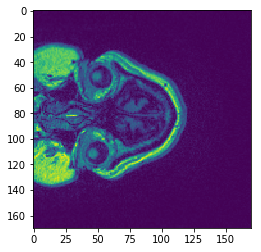

In [153]:
plt.imshow(ds[:,0,:])

(array([2337468.,       0.,       0.,       0.,   67779.,   73074.,   63090.,   62330.,   70164.,   61644.,
          72021.,   65507.,   68937.,   83878.,   78910.,   84749.,  102181.,   92511.,  106815.,   93273.,
          90206.,   97621.,   79689.,   76170.,   85032.,   73802.,   84230.,   73953.,   71259.,   75607.,
          58443.,   49412.,   45911.,   32456.,   31587.,   24713.,   23756.,   26462.,   22609.,   21487.,
          22438.,   18214.,   19054.,   15240.,   14018.,   14852.,   11564.,   10565.,   10784.,    8292.,
           8113.,    5989.,    5214.,    4797.,    3398.,    2675.,    2392.,    1592.,    1367.,     838.,
            689.,     606.,     434.,     300.,     222.,     169.,     125.,      89.,      76.,      43.,
             37.,      32.,      13.,       5.,      12.,       4.,       6.,       3.,       1.,       2.]),
 array([  0.   ,   7.375,  14.75 ,  22.125,  29.5  ,  36.875,  44.25 ,  51.625,  59.   ,  66.375,  73.75 ,
         81.125,  88.5  ,  

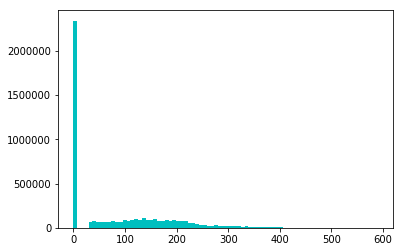

In [126]:
plt.hist(ds.flatten(), bins=80, color='c')

In [154]:
ds[ds<20]=0

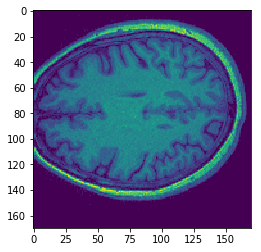

In [156]:
plt.imshow(ds[:,:,100])

In [404]:
ds = img.get_fdata()[15]
for i in range(16,161):
    ds = np.dstack((ds,img.get_fdata()[i]))
ds = ds.transpose(1,0,2)

#Select cut
ds_3d_a = ds[77,25:235,:]
for i in range(80,240,3):
    ds_3d_a = np.dstack((ds_3d_a,ds[i,25:235,:]))
ds_3d_a = ds_3d_a.transpose(2,0,1)
ds_3d_a = ds_3d_a / 2350

im.append(ds_3d_a)

In [405]:
np.asarray(im).shape

(1, 55, 210, 146)

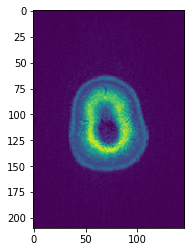

In [409]:
plt.imshow(np.asarray(im)[0,54,:,:])

In [173]:
dsr = resize(ds, (64, 64,64), mode='constant', anti_aliasing=True)

In [174]:
dsr.shape

(64, 64, 64)

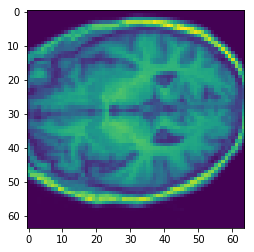

In [182]:
plt.imshow(dsr[:,:,25])

In [183]:
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [184]:
def plot_3d(image, threshold=0):

    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, c,dd = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

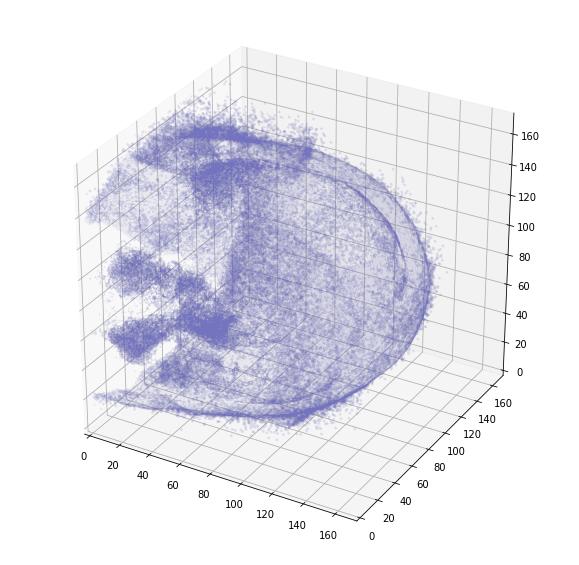

In [186]:
plot_3d(ds,0)

#### 64x64

In [188]:
# loop through all the DICOM files
image_array_train =[]

for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    ds = resize(ds.get_fdata()[3:173,50:220,60:230], (64, 64, 64), mode='constant', anti_aliasing=True)
    ds = ds.astype('float64')
    ds[ds<20]=0
    image_array_train.append(ds[:,:,:])


'''for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    ds_3d = resize(ds.get_fdata()[25,40:230,60:230], (128, 120), mode='constant', anti_aliasing=True)
    for i in range(28,146,3):
        ds_3d = np.dstack((ds_3d,resize(ds.get_fdata()[i,40:230,60:230], (128, 120),mode='constant', anti_aliasing=True)))

    image_array_train.append(ds_3d)

for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    ds_3d = resize(ds.get_fdata()[26,40:230,60:230], (128, 120), mode='constant', anti_aliasing=True)
    for i in range(29,147,3):
        ds_3d = np.dstack((ds_3d,resize(ds.get_fdata()[i,40:230,60:230], (128, 120),mode='constant', anti_aliasing=True)))

    image_array_train.append(ds_3d)

for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    ds_3d = resize(ds.get_fdata()[27,40:230,60:230], (128, 120), mode='constant', anti_aliasing=True)
    for i in range(30,148,3):
        ds_3d = np.dstack((ds_3d,resize(ds.get_fdata()[i,40:230,60:230], (128, 120),mode='constant', anti_aliasing=True)))

    image_array_train.append(ds_3d)
    
for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    ds_3d = resize(ds.get_fdata()[145,40:230,60:230], (128, 120), mode='constant', anti_aliasing=True)
    for i in range(142,24,-3):
        ds_3d = np.dstack((ds_3d,resize(ds.get_fdata()[i,40:230,60:230], (128, 120),mode='constant', anti_aliasing=True)))

    image_array_train.append(ds_3d)

for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    ds_3d = resize(ds.get_fdata()[146,40:230,60:230], (128, 120), mode='constant', anti_aliasing=True)
    for i in range(143,25,-3):
        ds_3d = np.dstack((ds_3d,resize(ds.get_fdata()[i,40:230,60:230], (128, 120),mode='constant', anti_aliasing=True)))

    image_array_train.append(ds_3d)

for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    ds_3d = resize(ds.get_fdata()[147,40:230,60:230], (128, 120), mode='constant', anti_aliasing=True)
    for i in range(144,26,-3):
        ds_3d = np.dstack((ds_3d,resize(ds.get_fdata()[i,40:230,60:230], (128, 120),mode='constant', anti_aliasing=True)))

    image_array_train.append(ds_3d)'''
    
image_array_train = np.asarray(image_array_train)
#image_array_train = image_array_train.transpose(image_array_train, (0,2,3,1))
#image_array_train = image_array_train/1278.008826530314

image_array_train.shape

(256, 64, 64, 64)

In [189]:
immin = 20
ptp = image_array_train.max() - immin

In [191]:
image_array_train -= immin
image_array_train /= ptp

In [193]:
image_array_val =[]

for filenameDCM in lstFilesDCM_val:
    ds = nib.load(filenameDCM)
    ds = resize(ds.get_fdata()[3:173,50:220,60:230], (64, 64, 64), mode='constant', anti_aliasing=True)
    ds = ds.astype('float64')
    ds[ds<20]=0
    image_array_val.append(ds[:,:,:])
image_array_val = np.asarray(image_array_val)
image_array_val.shape
image_array_val -= immin
image_array_val /= ptp

In [194]:
image_array_test =[]

for filenameDCM in lstFilesDCM_test:
    ds = nib.load(filenameDCM)
    ds = resize(ds.get_fdata()[3:173,50:220,60:230], (64, 64, 64), mode='constant', anti_aliasing=True)
    ds = ds.astype('float64')
    ds[ds<20]=0
    image_array_test.append(ds[:,:,:])
image_array_test = np.asarray(image_array_test)
image_array_test.shape
image_array_test -= immin
image_array_test /= ptp

In [195]:
y_train = X_train_tmp.Group.values
#y_train = np.hstack((y_train,y_train,y_train))
#y_train = np.hstack((y_train,y_train))
y_val = y_val_tmp.values
#y_val= np.hstack((y_val,y_val,y_val))
y_test = y_test_tmp.values
#y_val= np.hstack((y_val,y_val,y_val))

y_train= y_train.astype('int64')
y_val= y_val.astype('int64')
y_test= y_test.astype('int64')

y_train.shape,y_val.shape,y_test.shape

((256,), (111,), (92,))

### C3D

In [196]:
import C3D

In [197]:
class MetaModel(BasicModel):
    def get_layer_groups(self):
        m=self.model
        return m
        

In [198]:
class MetaArraysDataset(BaseDataset):
    def __init__(self, x,y, transform, path):
        self.path = path
        self.x,self.y= x, y
        assert(len(x)==len(y))
        super().__init__(transform)
        
    def __getitem__(self, idx):
        """ This function should return a list.
        """
        x = self.get_x(idx)
        y = self.get_y(idx)
        return self.get(self.transform, x, y)
   
    def get(self, tfm, x, y):
        if tfm is None:
            return [x, y] 
        x,y = tfm(x,y)
        return [x,y]
    def get_c(self): return int(self.y.max())+1
    def get_x(self, i): return self.x[i]
    def get_y(self, i): return self.y[i]
    def get_n(self): return len(self.y)
    def get_sz(self): return self.x.shape[1]

In [199]:
class  MetaLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.nll_loss

In [200]:
bs=4; sz=64
#f_model = resnet34

In [201]:
USE_GPU=False

In [202]:
class ModelMetaData(ImageClassifierData):
    
    @classmethod
    def get_ds(self, fn, trn, val, tfms, path, test=None):
        res = [
            fn(trn[0], trn[1],tfms[0], path), # train
            fn(val[0], val[1],tfms[1], path), # val
            fn(trn[0], trn[1],tfms[1], path), # fix
            fn(val[0], val[1],tfms[0], path)  # aug
        ]
        if test:
            test_lbls = np.zeros((len(test),1))
            res += [
                fn(test[0], test[1],tfms[1], path), # test
                fn(test[0], test[1] ,tfms[0], path)  # test_aug
            ]
        else: res += [None,None]
        return res
    
    @classmethod
    def from_csv(self, path, folder, csv_fname, bs=bs, tfms=(None,None),val_idxs=None, 
                 suffix='', test_name=None, skip_header=True, num_workers=4):
        fnames,x2,y = csv_source2(folder, csv_fname, skip_header, suffix)
        ((val_fnames, trn_fnames), (val_x2, trn_x2), (val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), x2, y)

        test_fnames = read_dir(path, test_name) if test_name else None
        datasets = self.get_ds(MetaDataset, (trn_fnames,trn_x2,trn_y), (val_fnames,val_x2,val_y),tfms=tfms, path=path)
        return self(path, datasets, bs, num_workers, classes=1)
    
    @classmethod
    def from_arrays(self, path, trn, val, test, bs=bs, tfms=(None,None), classes=None, num_workers=4):
        trn_x , val_x = trn[0],val[0]
        trn_y , val_y = trn[1],val[1]
        test_x, test_y= test[0],test[1]
        datasets = self.get_ds(MetaArraysDataset, (trn_x,trn_y), (val_x,val_y) ,test=(test_x,test_y) ,tfms=tfms,path=path)
        return self(path, datasets, bs, num_workers, classes=classes)
    
        
    def get_learner(self):
        model = C3D.C3D()
        #model = ConvWithMeta()
        #model = Darknet([1,2,4,6,3], num_classes=2, nf=32)
        #model = MetaResNet(BasicBlock, [3, 4, 6, 3])
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #m = nn.DataParallel(m, [1,2,3])
        return MetaLearner(self, MetaModel(model.to(device)), opt_fn=optim.Adam)

In [203]:
data = ModelMetaData.from_arrays('.', trn=(image_array_train,y_train)
                                 ,val=(image_array_val,y_val)
                                ,test=(image_array_test,y_test))

In [204]:
learner = data.get_learner()


In [205]:
learner.fit(1e-4,5,metrics=[accuracy])

epoch      trn_loss   val_loss                             
    0      0.679732   0.659118  



[0.6591176788012186]

## Load Training Set

In [44]:
image_array_train = []
image_array_train_a = []
image_array_train_ai = []
image_array_train_b = []
image_array_train_bi = []
image_array_train_c = []
image_array_train_ci = []

for filenameDCM in lstFilesDCM_train:
    img = nib.load(filenameDCM)
    ds = img.get_fdata()[20]
    for i in range(21,155):
        ds = np.dstack((ds,img.get_fdata()[i]))
    ds = ds.transpose(1,0,2)
    
    #Select cut
    ds_3d_a = ds[80,40:220,:]
    for i in range(83,241,3):
        ds_3d_a = np.dstack((ds_3d_a,ds[i,40:220,:]))        
    ds_3d_a = ds_3d_a.transpose(2,0,1)
    ds_3d_a = ds_3d_a / 2350
    image_array_train_a.append(ds_3d_a)
    gc.collect()
    
    
    ds_3d_ai = ds[80,40:220,::-1]
    for i in range(83,241,3):
        ds_3d_ai = np.dstack((ds_3d_ai,ds[i,40:220,::-1]))
    ds_3d_ai = ds_3d_ai.transpose(2,0,1)
    ds_3d_ai = ds_3d_ai / 2350
    image_array_train_ai.append(ds_3d_ai)
    gc.collect()
    
    ds_3d_b = ds[81,40:220,:]
    for i in range(84,242,3):
        ds_3d_b = np.dstack((ds_3d_b,ds[i,40:220,:]))
    ds_3d_b = ds_3d_b.transpose(2,0,1)
    ds_3d_b = ds_3d_b / 2350
    image_array_train_b.append(ds_3d_b)
    gc.collect()
    
    ds_3d_bi = ds[81,40:220,::-1]
    for i in range(84,242,3):
        ds_3d_bi = np.dstack((ds_3d_bi,ds[i,40:220,::-1]))
    ds_3d_bi = ds_3d_bi.transpose(2,0,1)
    ds_3d_bi = ds_3d_bi / 2350
    image_array_train_bi.append(ds_3d_bi)
    gc.collect()
    
    ds_3d_c = ds[82,40:220,:]
    for i in range(85,243,3):
        ds_3d_c = np.dstack((ds_3d_c,ds[i,40:220,:]))
    ds_3d_c = ds_3d_c.transpose(2,0,1)  
    ds_3d_c = ds_3d_c / 2350
    image_array_train_c.append(ds_3d_c)
    gc.collect()
    
    ds_3d_ci = ds[82,40:220,::-1]
    for i in range(85,243,3):
        ds_3d_ci = np.dstack((ds_3d_ci,ds[i,40:220,::-1]))
    ds_3d_ci = ds_3d_ci.transpose(2,0,1)
    ds_3d_ci = ds_3d_ci / 2350
    image_array_train_ci.append(ds_3d_ci)
    gc.collect()



In [45]:
image_array_train1 = np.vstack((image_array_train_a,image_array_train_ai))
image_array_train2 = np.vstack((image_array_train_b,image_array_train_bi))
image_array_train3 = np.vstack((image_array_train_c,image_array_train_ci))
image_array_train = np.vstack((image_array_train1,image_array_train2,image_array_train3))

image_array_train.shape

(2196, 54, 180, 135)

In [46]:
numpy.save('mri_train_array_upsamp', image_array_train)

In [9]:
#image_array_train = np.load('mri_train_array.npy')
image_array_train = np.load('mri_train_array_upsamp.npy')

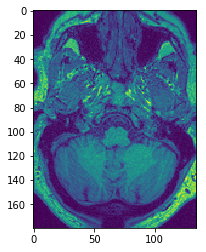

In [47]:
plt.imshow(image_array_train[400,0,:,:])

In [48]:
#Validation set

In [49]:
image_array_val =[]

    
for filenameDCM in lstFilesDCM_val:
    img = nib.load(filenameDCM)
    ds = img.get_fdata()[20]
    for i in range(21,155):
        ds = np.dstack((ds,img.get_fdata()[i]))
    ds = ds.transpose(1,0,2)
    
    #Select cut
    ds_3d = ds[80,40:220,:]
    for i in range(83,241,3):
        ds_3d = np.dstack((ds_3d,ds[i,40:220,:]))        
    ds_3d = ds_3d.transpose(2,0,1)
    ds_3d = ds_3d / 2350
    image_array_val.append(ds_3d)
    gc.collect()
    

image_array_val = np.asarray(image_array_val, dtype='float64')
image_array_val.shape

(111, 54, 180, 135)

In [50]:
image_array_val.shape

(111, 54, 180, 135)

In [51]:
numpy.save('mri_val_array_upsamp', image_array_val)

In [10]:
image_array_val = np.load('mri_val_array_upsamp.npy')

In [52]:
image_array_train = np.asarray(image_array_train,dtype='float64')
image_array_val = np.asarray(image_array_val,dtype='float64')

In [53]:
#Test set

In [54]:
image_array_test =[]

    
for filenameDCM in lstFilesDCM_test:
    img = nib.load(filenameDCM)
    ds = img.get_fdata()[20]
    for i in range(21,155):
        ds = np.dstack((ds,img.get_fdata()[i]))
    ds = ds.transpose(1,0,2)
    
    #Select cut
    ds_3d = ds[80,40:220,:]
    for i in range(83,241,3):
        ds_3d = np.dstack((ds_3d,ds[i,40:220,:]))        
    ds_3d = ds_3d.transpose(2,0,1)
    ds_3d = ds_3d / 2350
    image_array_test.append(ds_3d)
    gc.collect()
    

image_array_test = np.asarray(image_array_test, dtype='float64')
image_array_test.shape

(92, 54, 180, 135)

In [55]:
numpy.save('mri_test_array_upsamp', image_array_test)

### Data Augmented Image_array_train

In [43]:
from scipy.ndimage import interpolation

In [ ]:
rotR = interpolation.rotate(image_array_train,-5,axes=(3,2),mode='constant',reshape=False)
numpy.save('image_array_train_aug', rotR)

In [44]:
rotR8 = interpolation.rotate(image_array_train,-8,axes=(3,2),mode='constant',reshape=False)
np.save('image_array_train_aug3', rotR8)

In [ ]:
rotL = interpolation.rotate(image_array_train,5,axes=(3,2),mode='constant',reshape=False)
numpy.save('image_array_train_aug2', rotL)

In [ ]:
rotL8 = interpolation.rotate(image_array_train,8,axes=(3,2),mode='constant',reshape=False)
np.save('image_array_train_aug4', rotL8)

### Load Image Array

In [5]:
image_array_train = np.load('mri_train_array_upsamp.npy')
#image_array_train = np.load('image_array_train_aug.npy')
#image_array_train = np.load('image_array_train_aug2.npy')
#image_array_train = np.load('image_array_train_aug3.npy')
#image_array_train = np.load('image_array_train_aug4.npy')

image_array_val = np.load('mri_val_array_upsamp.npy')
image_array_test = np.load('mri_test_array_upsamp.npy')

### Y , Param

In [56]:
y_train = X_train_tmp.Group.values
y_train = y_train.astype('float64')
y_train = np.hstack((y_train,y_train,y_train))
y_train = np.hstack((y_train,y_train))
y_val = y_val_tmp.values
y_val = y_val.astype('float64')
#y_val= np.hstack((y_val,y_val,y_val))
y_test = y_test_tmp.values
y_test = y_test.astype('float64')
#y_val= np.hstack((y_val,y_val,y_val))

In [57]:
y_train.shape,y_val.shape,y_test.shape

((2196,), (111,), (92,))

In [58]:
numpy.save('mri_ytrain_array_upsamp', y_train)
numpy.save('mri_yval_array_upsamp', y_val)
numpy.save('mri_ytest_array_upsamp', y_test)

In [72]:
param_train = X_train_tmp[['is_M','is_F','age_scale']].values
params = []
for i in param_train:
    #stack = []
    #stack.append(i)
    #stack = stack*10
    params.append(i)
param_train = np.asarray(params)
del(params)

In [75]:
param_val = param_val_tmp.values
params = []
for i in param_val:
    #stack = []
    #stack.append(i)
    #stack = stack*10
    params.append(i)
param_val = np.asarray(params)
del(params)

param_test = param_test_tmp.values
params = []
for i in param_test:
    #stack = []
    #stack.append(i)
    #stack = stack*10
    params.append(i)
param_test = np.asarray(params)
del(params)

In [76]:
param_train = param_train.astype('float64')
param_val = param_val.astype('float64')
param_test = param_test.astype('float64')

In [77]:
#x6 Param match training Image
param_train = np.vstack((param_train,param_train,param_train))
param_train = np.vstack((param_train,param_train))

In [78]:
param_train.shape

(2196, 3)

In [79]:
numpy.save('mri_paramtrain_array_upsamp', param_train)
numpy.save('mri_paramval_array_upsamp', param_val)
numpy.save('mri_paramtest_array_upsamp', param_test)

### Load y,param

In [6]:
y_val = np.load('mri_yval_array_upsamp.npy')
y_train = np.load('mri_ytrain_array_upsamp.npy')
y_test = np.load('mri_ytest_array_upsamp.npy')
param_val = np.load('mri_paramval_array_upsamp.npy')
param_train = np.load('mri_paramtrain_array_upsamp.npy')
param_test = np.load('mri_paramtest_array_upsamp.npy')

In [7]:
y_train = y_train.astype('float64')
y_val = y_val.astype('float64')

### 2D

#### Pretrained Resnet

In [77]:
class  ConvWithMeta(nn.Module):
    def __init__(self):
        super(ConvWithMeta, self).__init__()
        head_layer = [nn.Conv2d(1, 3, kernel_size=1, bias=False, stride=1, padding=0)]
        self.head_layer = nn.Sequential(*head_layer)
        resnet_layers = list(resnet34(True).children())[:8]
        self.features = nn.Sequential(*resnet_layers,nn.Dropout2d(0.5))
        for param in self.features.parameters():
            param.requires_grad = False
        self.bns = nn.ModuleList([nn.BatchNorm1d(27660), nn.BatchNorm1d(1024)])
        self.lins = nn.ModuleList([nn.Linear(27660,1024), nn.Linear(1024, 1)])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.fc_model = nn.Sequential(*self.fc_layers()).cuda()
        
    def fc_layers(self):
        return [self.bns[0], nn.Dropout(0.5), self.lins[0], nn.LeakyReLU(), 
                self.bns[1], nn.Dropout(0.5), self.lins[1]] 
        
    def forward(self, x1, x2):
        for i in range(54):
            x_clone = x1[:,i,:,:].clone()
            x_clone = x_clone.unsqueeze(1)
            x_clone = self.head_layer(x_clone)           
            x_clone = self.features(x_clone)
            x_clone = nn.AdaptiveMaxPool2d((1,1))(x_clone)
            if i == 0:
                out = x_clone
            else:
                out = torch.cat((out,x_clone),1)
        out=out.squeeze()
        out = torch.cat((out,x2[:,0],x2[:,1],x2[:,2],x2[:,3]),1)
        out = self.fc_model(out)
        return out.squeeze()
        '''
        x1 = x1.unsqueeze(1)
        x1 = self.head_layer(x1)
        x1 = self.features(x1)
        x1 = nn.AdaptiveMaxPool2d((1,1))(x1)
        x1 = x1.view(x1.size(0), -1)
        x = torch.cat([x1, x2], 1)
        x = self.fc_model(x)
        x = x.squeeze()
        return x'''

In [78]:
class MetaModel(BasicModel):
    def get_layer_groups(self):
        m=self.model
        return m

In [79]:
class  MetaLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.binary_cross_entropy_with_logits

In [80]:
class MetaDataset(BaseDataset):
    """ Dataset where x=(x1,x2) where x1 is an image.
    """
    def __init__(self, fnames, x2, y, transform, path):
        self.path,self.fnames,self.y,self.x2 = path,fnames,y,x2
        assert(len(fnames)==len(y))
        super().__init__(transform)

    def __getitem__(self, idx):
        """ This function should return a list.
        """
        x1, x2 = self.get_x(idx)
        y = self.get_y(idx)
        return self.get(self.transform, (x1, x2), y)
    
    def __len__(self): return len(self.y)
    
    def get_x(self, i):
        im = x1
        x2 = np.expand_dims(self.x2[i], axis=1)
        return np.array(im, dtype=np.float32)/255., x2
    
    def get_n(self): return len(self.y)
    def get_y(self, i): return self.y[i]
    
    def get(self, tfm, x, y):
        x1, x2 = x
        if tfm is None:
            return [x1, x2, y] 
        x1,y = tfm(x1,y)
        return [x1, x2, y]
    
    def get_c(self): return 1
    
    def get_sz(self): return self.transform.sz

In [81]:
class MetaArraysDataset(BaseDataset):
    def __init__(self, x, param, y, transform, path):
        self.path = path
        self.x,self.y, self.param = x, y , param
        assert(len(x)==len(y))
        super().__init__(transform)
        
    def __getitem__(self, idx):
        """ This function should return a list.
        """
        x = self.get_x(idx)
        param = self.get_param(idx)
        y = self.get_y(idx)
        return self.get(self.transform, (x, param), y)
   
    def get(self, tfm, x, y):
        x1, x2 = x
        if tfm is None:
            return [x1, x2, y] 
        x1,y = tfm(x1,y)
        return [x1, x2, y]
    def get_c(self): return int(self.y.max())+1
    def get_x(self, i): return self.x[i]
    def get_param(self,i): return self.param[i]
    def get_y(self, i): return self.y[i]
    def get_n(self): return len(self.y)
    def get_sz(self): return self.x.shape[1]

In [82]:
bs=4; sz=128
#f_model = resnet34

In [83]:
USE_GPU=True

In [84]:
class ModelMetaData(ImageClassifierData):
    
    @classmethod
    def get_ds(self, fn, trn, val, tfms, path, test=None):
        res = [
            fn(trn[0], trn[1], trn[2], tfms[0], path), # train
            fn(val[0], val[1], val[2], tfms[1], path), # val
            fn(trn[0], trn[1], trn[2], tfms[1], path), # fix
            fn(val[0], val[1], val[2], tfms[0], path)  # aug
        ]
        if test:
            test_lbls = np.zeros((len(test),1))
            res += [
                fn(test, test_lbls, tfms[1], path), # test
                fn(test, test_lbls, tfms[0], path)  # test_aug
            ]
        else: res += [None,None]
        return res
    
    @classmethod
    def from_csv(self, path, folder, csv_fname, bs=bs, tfms=(None,None),val_idxs=None, 
                 suffix='', test_name=None, skip_header=True, num_workers=4):
        fnames,x2,y = csv_source2(folder, csv_fname, skip_header, suffix)
        ((val_fnames, trn_fnames), (val_x2, trn_x2), (val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), x2, y)

        test_fnames = read_dir(path, test_name) if test_name else None
        datasets = self.get_ds(MetaDataset, (trn_fnames,trn_x2,trn_y), (val_fnames,val_x2,val_y),tfms=tfms, path=path)
        return self(path, datasets, bs, num_workers, classes=1)
    
    @classmethod
    def from_arrays(self, path, trn, val, bs=bs, tfms=(None,None), classes=None, num_workers=4, test=None):
        trn_x1 , val_x1 = trn[0],val[0]
        trn_x2 , val_x2 = trn[1],val[1]
        trn_y , val_y = trn[2],val[2]
        #test_x1, test_x2, test_y = test[0],test[1],test[2]
        datasets = self.get_ds(MetaArraysDataset, (trn_x1,trn_x2,trn_y), (val_x1,val_x2,val_y) ,tfms=tfms,path=path)
        return self(path, datasets, bs, num_workers, classes=classes)
    
        
    def get_learner(self):
        model = ConvWithMeta()
        #model = Darknet([1,2,4,6,3], num_classes=1, nf=32)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #m = nn.DataParallel(m, [1,2,3])
        return MetaLearner(self, MetaModel(model.to(device)), opt_fn=optim.Adam)

In [85]:
data = ModelMetaData.from_arrays('.', trn=(image_array_train,param_train,y_train),val=(image_array_val,param_val,y_val))

In [86]:
learner = data.get_learner()


In [18]:
learner.lr_find()

 62%|██████▎   | 240/384 [08:47<05:16,  2.20s/it, loss=2.07]

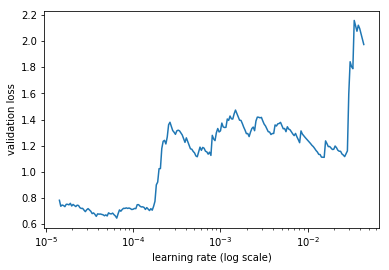

In [20]:
learner.sched.plot()

In [88]:
learner.fit(1e-4,2)

epoch      trn_loss   val_loss                               
    0      0.419343   0.90033   
 12%|█▏        | 46/384 [01:37<11:55,  2.12s/it, loss=0.489]

KeyboardInterrupt: 

In [89]:
from scipy.special import expit
pred = expit(learner.predict())
pred

array([0.98131, 0.98352, 0.88849, 0.99101, 0.98836, 0.99982, 0.94574, 0.80097, 0.89086, 0.9931 , 0.81136,
       0.98023, 0.98714, 0.99649, 0.95826, 0.84595, 0.99708, 0.92609, 0.99952, 0.94614, 0.94075, 0.87874,
       0.97801, 0.99228, 0.98609, 0.93586, 0.95878, 0.29151, 0.98643, 0.98963, 0.98258, 0.79172, 0.84671,
       0.99149, 0.9826 , 0.98758, 0.986  , 0.98032, 0.9946 , 0.92846, 0.9951 , 0.86302, 0.53077, 0.69919,
       0.99925, 0.99777, 0.95551, 0.96029, 0.90396, 0.97007, 0.98139, 0.99862, 0.99899, 0.71701, 0.99094,
       0.99123, 0.96666, 0.99358, 0.97375, 0.99657, 0.99441, 0.99375, 0.9952 , 0.83555, 0.92499, 0.95271,
       0.86417, 0.95752, 0.99551, 0.99873, 0.99867, 0.9856 , 0.99273, 0.98916, 0.72795, 0.90337, 0.80713,
       0.99334, 0.99902, 0.98052, 0.21823, 0.99586, 0.99576, 0.99953, 0.99961, 0.99594, 0.98331, 0.92618,
       0.99301, 0.66916, 0.9958 , 0.45879, 0.98861, 0.55469, 0.99082, 0.99689, 0.64341, 0.99745, 0.87676,
       0.98962, 0.98702, 0.98046, 0.96546, 0.9

In [283]:
predict=[]
for i in pred:
    if i >= 0.3:
        predict.append(1)
    else:
        predict.append(0)

In [284]:
fin = ((y_val)==np.array(predict))

In [285]:
print('Accuracy')
np.count_nonzero(fin == True) / len(fin)

Accuracy


0.7567567567567568

In [286]:
print('False negative')
np.sum((y_val)>np.array(predict))/len(fin)

False negative


0.018018018018018018

In [287]:
print('False positive')
np.sum((y_val)<np.array(predict))/len(fin)

False positive


0.22522522522522523

In [288]:
sklearn.metrics.precision_recall_fscore_support(y_val, np.array(predict))

(array([0.     , 0.77064]),
 array([0.     , 0.97674]),
 array([0.     , 0.86154]),
 array([25, 86]))

In [76]:
learner.save('3D_MRI_resnet34_classify_PD')

In [87]:
learner.load('3D_MRI_resnet34_classify_PD')

In [29]:
lr=[3e-5,6e-5,1e-4]

In [30]:
for j in range(2):
    for i in lr:
        print(i)
        learner.fit(i,1)

3e-05


epoch      trn_loss   val_loss                               
    0      0.380577   0.818091  

6e-05


epoch      trn_loss   val_loss                               
    0      0.384501   0.932408  

0.0001


epoch      trn_loss   val_loss                               
    0      0.54069    1.057876  

3e-05


epoch      trn_loss   val_loss                               
    0      0.348768   1.057993  

6e-05


epoch      trn_loss   val_loss                               
    0      0.451195   1.031317  

0.0001


epoch      trn_loss   val_loss                               
    0      0.428745   1.181388  



In [34]:
np.count_nonzero(y_val == 1) / len(y_val)

0.7747747747747747

### Darknet 3D

In [7]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv3d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm3d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=False))

class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x.add_(self.conv2(self.conv1(x.clone())))

class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        #Weight init Kaiming's
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
                
        features = [conv_layer(1, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            features += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2                        
        features += [nn.AdaptiveAvgPool3d(3), Flatten()]        
        self.features = nn.Sequential(*features)
        fc1 = [nn.Linear(13824, 1024), nn.LeakyReLU(negative_slope=0.1, inplace=False), nn.Dropout(0.2)]
        self.fc1 = nn.Sequential(*fc1)
        fc2 = [nn.Linear(1027, 64), nn.LeakyReLU(negative_slope=0.1, inplace=False),nn.Dropout(0.1)]
        self.fc2 = nn.Sequential(*fc2)
        self.layers = nn.Sequential(nn.Linear(64,1))
        
    def forward(self, x, y):
        x = x.unsqueeze(1)
        x = self.features(x)
        x = self.fc1(x)
        y = y.view(-1,1,3)
        x = torch.cat((x,y[:,:,0],y[:,:,1],y[:,:,2]),1)
        x = self.fc2(x)       
        x = self.layers(x)
        return x.view(-1)


In [8]:
class MetaModel(BasicModel):
    def get_layer_groups(self):
        m=self.model
        return m
        

In [9]:
class  MetaLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.binary_cross_entropy_with_logits

In [10]:
class MetaDataset(BaseDataset):
    """ Dataset where x=(x1,x2) where x1 is an image.
    """
    def __init__(self, fnames, x2, y, transform, path):
        self.path,self.fnames,self.y,self.x2 = path,fnames,y,x2
        assert(len(fnames)==len(y))
        super().__init__(transform)

    def __getitem__(self, idx):
        """ This function should return a list.
        """
        x1, x2 = self.get_x(idx)
        y = self.get_y(idx)
        return self.get(self.transform, (x1, x2), y)
    
    def __len__(self): return len(self.y)
    
    def get_x(self, i):
        im = x1
        x2 = np.expand_dims(self.x2[i], axis=1)
        return np.array(im, dtype=np.float32)/255., x2
    
    def get_n(self): return len(self.y)
    def get_y(self, i): return self.y[i]
    
    def get(self, tfm, x, y):
        x1, x2 = x
        if tfm is None:
            return [x1, x2, y] 
        x1,y = tfm(x1,y)
        return [x1, x2, y]
    
    def get_c(self): return 1
    
    def get_sz(self): return self.transform.sz

In [11]:
class MetaArraysDataset(BaseDataset):
    def __init__(self, x, param, y, transform, path):
        self.path = path
        self.x,self.y, self.param = x, y , param
        assert(len(x)==len(y))
        super().__init__(transform)
        
    def __getitem__(self, idx):
        """ This function should return a list.
        """
        x = self.get_x(idx)
        param = self.get_param(idx)
        y = self.get_y(idx)
        return self.get(self.transform, (x, param), y)
   
    def get(self, tfm, x, y):
        x1, x2 = x
        if tfm is None:
            return [x1, x2, y] 
        x1,y = tfm(x1,y)
        return [x1, x2, y]
    def get_c(self): return int(self.y.max())+1
    def get_x(self, i): return self.x[i]
    def get_param(self,i): return self.param[i]
    def get_y(self, i): return self.y[i]
    def get_n(self): return len(self.y)
    def get_sz(self): return self.x.shape[1]

In [12]:
bs=4; sz=180
#f_model = resnet34

In [13]:
USE_GPU=True

In [14]:
class ModelMetaData(ImageClassifierData):
    
    @classmethod
    def get_ds(self, fn, trn, val, tfms, path, test=None):
        res = [
            fn(trn[0], trn[1], trn[2], tfms[0], path), # train
            fn(val[0], val[1], val[2], tfms[1], path), # val
            fn(trn[0], trn[1], trn[2], tfms[1], path), # fix
            fn(val[0], val[1], val[2], tfms[0], path)  # aug
        ]
        if test:
            test_lbls = np.zeros((len(test),1))
            res += [
                fn(test[0], test[1], test[2] , tfms[1], path), # test
                fn(test[0], test[1] , test[2], tfms[0], path)  # test_aug
            ]
        else: res += [None,None]
        return res
    
    @classmethod
    def from_csv(self, path, folder, csv_fname, bs=bs, tfms=(None,None),val_idxs=None, 
                 suffix='', test_name=None, skip_header=True, num_workers=4):
        fnames,x2,y = csv_source2(folder, csv_fname, skip_header, suffix)
        ((val_fnames, trn_fnames), (val_x2, trn_x2), (val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), x2, y)

        test_fnames = read_dir(path, test_name) if test_name else None
        datasets = self.get_ds(MetaDataset, (trn_fnames,trn_x2,trn_y), (val_fnames,val_x2,val_y),tfms=tfms, path=path)
        return self(path, datasets, bs, num_workers, classes=1)
    
    @classmethod
    def from_arrays(self, path, trn, val, test, bs=bs, tfms=(None,None), classes=None, num_workers=4):
        trn_x1 , val_x1 = trn[0],val[0]
        trn_x2 , val_x2 = trn[1],val[1]
        trn_y , val_y = trn[2],val[2]
        test_x1, test_x2 , test_y= test[0],test[1],test[2]
        datasets = self.get_ds(MetaArraysDataset, (trn_x1,trn_x2,trn_y), (val_x1,val_x2,val_y) ,test=(test_x1, test_x2, test_y) ,tfms=tfms,path=path)
        return self(path, datasets, bs, num_workers, classes=classes)
    
        
    def get_learner(self):
        model = Darknet([1,2,4,3], num_classes=1, nf=32)
        #model = Darknet([1,2,4,6,3], num_classes=1, nf=32)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #m = nn.DataParallel(m, [1,2,3])
        return MetaLearner(self, MetaModel(model.to(device)), opt_fn=optim.Adam)

In [15]:
data = ModelMetaData.from_arrays('.', trn=(image_array_train,param_train,y_train)
                                 ,val=(image_array_val,param_val,y_val)
                                ,test=(image_array_test,param_test,y_test))

In [16]:
learner = data.get_learner()


In [51]:
learner.load('3D_MRI_classifyPD_with_upsamp')

In [17]:
learner.lr_find()

 35%|███▍      | 190/549 [23:00<43:29,  7.27s/it, loss=0.698] 

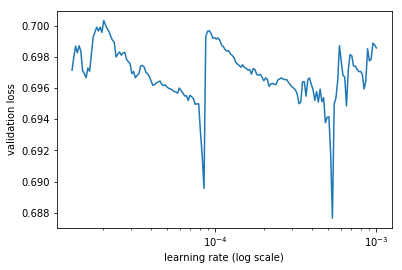

In [18]:
learner.sched.plot()

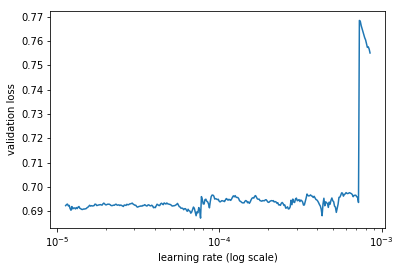

In [20]:
learner.sched.plot()

In [ ]:
learner.fit(5e-4,3)

epoch      trn_loss   val_loss                                 
    0      0.69153    0.662221  
    1      15.465779  0.638096                                
 81%|████████▏ | 447/549 [54:03<12:20,  7.26s/it, loss=0.677]

In [44]:
learner.save('3D_MRI_classifyPD_with_upsamp')

In [35]:
learner.fit(5e-4,5)

epoch      trn_loss   val_loss                                 
    0      0.678107   0.6456    
    1      0.847811   0.702818                                 
    2      0.685055   0.625003                                 
    3      0.692408   0.62811                                  
  3%|▎         | 17/549 [02:03<1:04:21,  7.26s/it, loss=0.693]

KeyboardInterrupt: 

In [37]:
from scipy.special import expit
td = expit(learner.predict())
td

array([0.5622 , 0.52643, 0.56432, 0.52737, 0.56328, 0.52594, 0.56422, 0.52689, 0.56353, 0.56377, 0.56365,
       0.56397, 0.56424, 0.52721, 0.56329, 0.56418, 0.52705, 0.5271 , 0.56399, 0.56262, 0.56416, 0.5266 ,
       0.52662, 0.52691, 0.56273, 0.56451, 0.56384, 0.56423, 0.56317, 0.56388, 0.52708, 0.52688, 0.56409,
       0.56451, 0.56299, 0.52722, 0.52718, 0.5637 , 0.52709, 0.52703, 0.56408, 0.56387, 0.56386, 0.5636 ,
       0.56414, 0.52732, 0.56385, 0.52687, 0.52745, 0.56485, 0.56406, 0.52755, 0.52748, 0.56437, 0.52665,
       0.52654, 0.56365, 0.56406, 0.52711, 0.52657, 0.5636 , 0.56336, 0.52786, 0.56446, 0.52694, 0.56383,
       0.5648 , 0.52677, 0.52699, 0.52685, 0.52759, 0.5646 , 0.5269 , 0.52742, 0.56396, 0.56365, 0.56449,
       0.56414, 0.56333, 0.52686, 0.52632, 0.564  , 0.56394, 0.56327, 0.52698, 0.56476, 0.56435, 0.52711,
       0.56332, 0.56323, 0.5639 , 0.5634 , 0.56402, 0.52742, 0.52792, 0.52706, 0.52674, 0.52695, 0.52768,
       0.56468, 0.5275 , 0.56257, 0.52779, 0.5

In [38]:
predict=[]
for i in pred:
    if i >= 0.3:
        predict.append(1)
    else:
        predict.append(0)

NameError: name 'pred' is not defined

In [ ]:
fin = ((y_val)==np.array(predict))

In [ ]:
print('Accuracy')
np.count_nonzero(fin == True) / len(fin)

In [286]:
print('False negative')
np.sum((y_val)>np.array(predict))/len(fin)

False negative


0.018018018018018018

In [287]:
print('False positive')
np.sum((y_val)<np.array(predict))/len(fin)

False positive


0.22522522522522523

In [288]:
sklearn.metrics.precision_recall_fscore_support(y_val, np.array(predict))

(array([0.     , 0.77064]),
 array([0.     , 0.97674]),
 array([0.     , 0.86154]),
 array([25, 86]))